## Подключение библиотек

In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import roc_auc_score

import scipy

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

## Загрузка данных

In [2]:
f = open(r'linear_train.txt','r',encoding='utf-8')
words=[]
target=[]
for line in f:
    words.append(line.split(', ')[0])
    target.append(line.split(', ')[1][0])

    
data=pd.DataFrame(words, columns=['name'])
data['tar']=target
data['tar']=data['tar'].astype(int)
target=pd.DataFrame(target, columns=['tar'])
target['tar']=target
target['tar']=target['tar'].astype('int')
f.close()


f1 = open(r'linear_test.txt','r',encoding='utf-8')
words1=[]
for line in f1:
    words1.append(line.split('\n')[0])
lin_test=pd.DataFrame(words1, columns=['name'])
f1.close()


data_res=data.copy()
target_res=target.copy()

In [3]:
data.head(15)

,name,tar
0,Аалтонен,1
1,Аар,0
2,Аарон,0
3,ААРОН,0
4,Аарона,0
5,Аарона,1
6,Аароне,0
7,Ааронов,0
8,Аахена,0
9,Абабков,1


## Формирование признаков

In [4]:
# Посмотрим сбланасированы ли классы
data.tar.value_counts()

0    90770
1    10638
Name: tar, dtype: int64

Видно, что классы сильно несбалансированы и отличаются почти в 9 раз, воспльзуемся андерсэмплингом для балансирвоки классов пока будем смотреть на влияние признаков на целевую переменную

### Undersampling

In [5]:
# Сформируем массив индексов, которые мы исключим
ind=data[data['tar'] == 0].index
list_ind=list(ind)
drop_ind=set(list_ind[0:len(list_ind):9])^set(list_ind)
ind_1=pd.Int64Index(drop_ind)
print(len(drop_ind))

80684


In [6]:
#Сбалансируем классы
data.drop(drop_ind,inplace=True)
data.tar.value_counts()

1    10638
0    10086
Name: tar, dtype: int64

In [7]:
# Заглавная буква
def first_letter(data):
    data['big_sym']=[s.istitle() for s in data.name]
    data['big_sym']=data['big_sym'].astype('int')


first_letter(data)

In [8]:
(data[data['big_sym'] == 1]['tar']).value_counts()#['tar'] == 0)#.value_counts()

1    8716
0    3045
Name: tar, dtype: int64

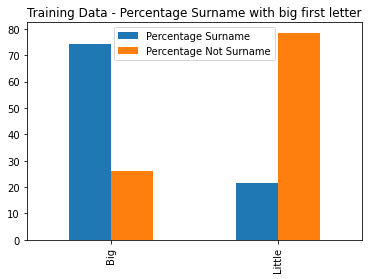

In [9]:
def plot_big_sym(data):
    title_b_distribution = round((data[data['big_sym'] == 1]['tar']).value_counts()[1]/len(data[data['big_sym'] == 1]) * 100, 2)
    title_l_distribution = round((data[data['big_sym'] == 0]['tar']).value_counts()[1]/len(data[data['big_sym'] == 0]) * 100, 2)
    big_sym_df = pd.DataFrame(
    { "Percentage Surname":{"Big": title_b_distribution,"Little": title_l_distribution},  
     "Percentage Not Surname":{"Big": 100-title_b_distribution,"Little": 100-title_l_distribution}})
    big_sym_df.plot.bar().set_title("Training Data - Percentage Surname with big first letter")
    
plot_big_sym(data)

Получается, что если буква маленькая, то слово скорее не является фамилией, а если буква большая, то вероятность, что слово является фамилией больше. 

In [10]:
# Длина слова

def word_len(data):
    data['len']=[len(s) for s in data.name]
    data['len']=data['len'].astype(int)

    
word_len(data)

D:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='len', ylabel='Density'>

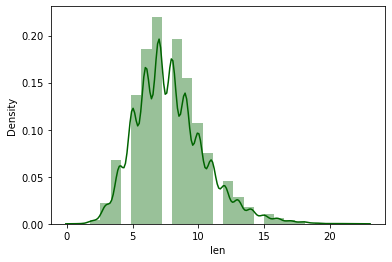

In [11]:
sns.distplot(data['len'],color='darkgreen',bins=27)

In [12]:
data.len.describe()

count    20724.000000
mean         7.853214
std          2.631821
min          1.000000
25%          6.000000
50%          8.000000
75%          9.000000
max         22.000000
Name: len, dtype: float64

In [13]:
# Сделаем длину категориальным признаком,а не вещественным
def det_range(a):
    if a>=10:
        return '>10'
    if a==9:
        return '9'
    if a==8:
        return '8'
    if a==7:
        return '7'
    if a==6:
        return '6'
    if a==5:
        return '5'
    if a==4:
        return '4'
    if a<=3:
        return '<3'
    
def len_range(data):
    data['len_range']=[det_range(s) for s in data.len]
    data.drop('len', axis=1, inplace=True)
len_range(data)

In [14]:
data.len_range.value_counts()

>10    4801
7      3546
8      3165
6      2999
9      2495
5      2208
4      1094
<3      416
Name: len_range, dtype: int64

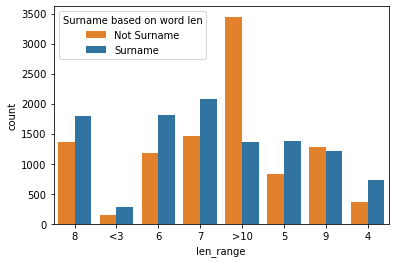

In [15]:
def plot_len(data):
    x = sns.countplot(x = "len_range", hue = "tar", data = data, palette=["C1", "C0"]).legend(labels = ["Not Surname", "Surname"])
    x.set_title("Surname based on word len")
    
plot_len(data)

Как видно многие категории длины слова вообще неинформативны, например, 9, так как слово практически с одинаковой вероятностью может быть как фамилией, так и нет. А категория > 10 показывает, что при такой длине слов скорее может являться не фамилией

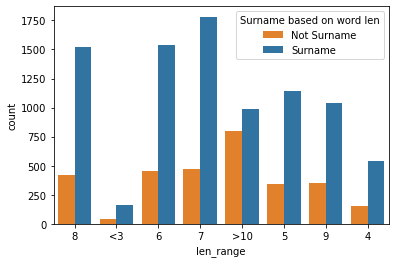

In [16]:
plot_len(data[data['big_sym']==1])

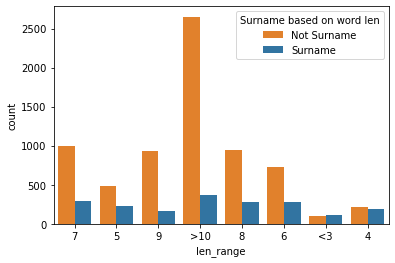

In [17]:
plot_len(data[data['big_sym']==0])

Видно, что слова длины меньше или равное 4 чаще являются фамилией, а слова длины более или равные 10, начинающиеся с маленькой буквы, чаще являются не фамилией. 

In [18]:
#Наличие сторонних символов
def rubber(data):
    symbols=[r'"', '.', ',', '-']
    data['rubber']=[s not in symbols for s in data.name ]
    data['rubber']=data['rubber'].astype('int')
    
rubber(data)    

In [19]:
data.rubber.value_counts()

1    20724
Name: rubber, dtype: int64

При таком раскладе весьма бесполезный признак

In [20]:
data.drop('rubber', axis=1, inplace=True)

In [21]:
#Окончания 
def ending(data):
    data['ending']=[s[-3:] for s in data.name]
    
ending(data)

In [22]:
data['ending'].describe()

count     20724
unique     3664
top         ами
freq        462
Name: ending, dtype: object

In [23]:
a=data.ending.value_counts()
d=dict(a)
end_list=[]
for x in d:
    if d[x]>180:
        end_list.append(x)

In [24]:
def remove_end(end_list, a):
    if a not in end_list:
        return 0
    else:
        return a
    
def replace_end(data):
    data['new_end']=[remove_end(end_list, s) for s in data.ending ]

In [25]:
replace_end(data)

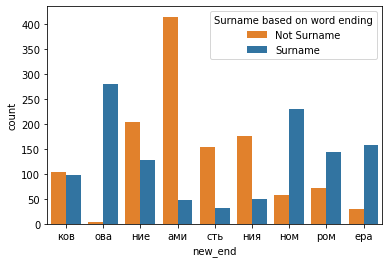

In [26]:
def plot_end(data):
    x = sns.countplot(x = "new_end", hue = "tar", data = data, palette=["C1", "C0"]).legend(labels = ["Not Surname", "Surname"])
    x.set_title("Surname based on word ending")
    
plot_end(data[data['new_end']!=0])

Видно, что окончание "ова", "ном" и "ера" чаще всего являются окончаниями для фамилий, а "ами"  "сть" и "ния" окончанием обычных слов.

In [27]:
#Число гласных и согласных
let_list=["а","ы", "е", "ю", "я", "ё", "и", "о", "у", "э", "А","Ы", "Е", "Ю", "Я", "Ё", "И", "О", "У", "Э"]
def v_count_in_word(name,let_list):
    count=0
    for x in name:
        if x in let_list:
            count+=1
    return count
 
def c_count_in_word(name,let_list):
    count=0
    for x in name:
        if x not in let_list:
            count+=1
    return count

def let_count(data, let_list):        
    data['vowels_let']=[v_count_in_word(s,let_list) for s in data.name ]
    data['cons_let']=[c_count_in_word(s,let_list) for s in data.name ]
        

let_count(data, let_list)

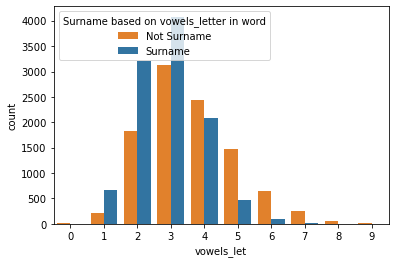

In [28]:
def plot_v_let(data):
    x = sns.countplot(x = "vowels_let", hue = "tar", data = data, palette=["C1", "C0"]).legend(labels = ["Not Surname", "Surname"])
    x.set_title("Surname based on vowels_letter in word")
    
plot_v_let(data)

Из полученных графиков можно сделать вывод, что в фамилиях тчаще всего встречаются 1,2,3 гласных буквы, а 5,6,7,8 в других словах

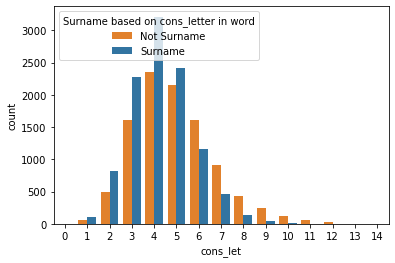

In [29]:
def plot_c_let(data):
    x = sns.countplot(x = "cons_let", hue = "tar", data = data, palette=["C1", "C0"]).legend(labels = ["Not Surname", "Surname"])
    x.set_title("Surname based on cons_letter in word")
    
plot_c_let(data)

Из полученных графиков можно сделать вывод, что в фамилиях тчаще всего встречаются 1,2,3,4 согласных буквы, а 6-12 в других словах

In [30]:
#Все буквы заглавные
def supper(data):
    data['supper']=[s.isupper() for s in data.name ]
    data['supper']=data['supper'].astype('int')
    
supper(data)



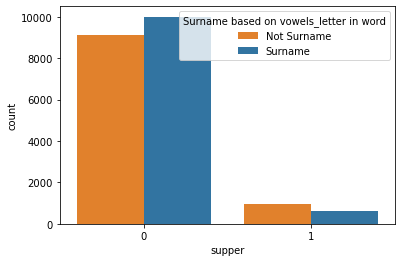

In [31]:
def plot_sup_let(data):
    x = sns.countplot(x = "supper", hue = "tar", data = data, palette=["C1", "C0"]).legend(labels = ["Not Surname", "Surname"])
    x.set_title("Surname based on vowels_letter in word")
    
plot_sup_let(data)

Практически неинформативный признак, исключим его

In [32]:
data.drop('supper', axis=1, inplace=True)

In [33]:
data.head()

,name,tar,big_sym,len_range,ending,new_end,vowels_let,cons_let
0,Аалтонен,1,1,8,нен,0,4,4
1,Аар,0,1,<3,Аар,0,2,1
5,Аарона,1,1,6,она,0,4,2
9,Абабков,1,1,7,ков,ков,3,4
12,абажуры,0,0,7,уры,0,4,3


In [34]:
#Закодируем категориальные признаки
cat_feat=['len_range', 'new_end']
len_data=pd.get_dummies(data['len_range'],prefix='len')
ind=len_data.columns
data[ind]=len_data[ind]
data.drop('len_range', axis=1, inplace=True)

In [35]:

end_data=pd.get_dummies(data['new_end'])
ind1=end_data.columns
data[ind1]=end_data[ind1]
data.drop('new_end', axis=1, inplace=True)

In [36]:
#Удалим все ненужные столбцы
data.drop('ending', axis=1, inplace=True)
data.drop('name', axis=1, inplace=True)

In [37]:
(data.corr()['tar'])

tar           1.000000
big_sym       0.522019
vowels_let   -0.293089
cons_let     -0.212151
len_4         0.071853
len_5         0.076222
len_6         0.075891
len_7         0.066080
len_8         0.047328
len_9        -0.021279
len_<3        0.040929
len_>10      -0.253640
0             0.016556
ами          -0.123690
ера           0.063307
ков          -0.006085
ние          -0.032619
ния          -0.061016
ном           0.068300
ова           0.111865
ром           0.031658
сть          -0.065300
Name: tar, dtype: float64

In [38]:
balance_target=data['tar']
data.drop('tar', axis=1, inplace=True)

In [39]:
data

,big_sym,vowels_let,cons_let,len_4,len_5,len_6,len_7,len_8,len_9,len_<3,...,0,ами,ера,ков,ние,ния,ном,ова,ром,сть
0,1,4,4,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,2,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
5,1,4,2,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9,1,3,4,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
12,0,4,3,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101383,0,3,3,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
101389,0,2,2,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
101393,0,3,3,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
101402,0,3,2,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [40]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
big_sym,20724.0,0.567506,0.495434,0.0,0.0,1.0,1.0,1.0
vowels_let,20724.0,3.256032,1.261486,0.0,2.0,3.0,4.0,9.0
cons_let,20724.0,4.597182,1.668654,0.0,3.0,4.0,6.0,14.0
len_4,20724.0,0.052789,0.223617,0.0,0.0,0.0,0.0,1.0
len_5,20724.0,0.106543,0.308539,0.0,0.0,0.0,0.0,1.0
len_6,20724.0,0.144711,0.351818,0.0,0.0,0.0,0.0,1.0
len_7,20724.0,0.171106,0.376611,0.0,0.0,0.0,0.0,1.0
len_8,20724.0,0.152721,0.359728,0.0,0.0,0.0,0.0,1.0
len_9,20724.0,0.120392,0.325427,0.0,0.0,0.0,0.0,1.0
len_<3,20724.0,0.020073,0.140255,0.0,0.0,0.0,0.0,1.0


# Разбиение данных на обучающую и валидационную выборку 

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [42]:
data_bal=data_res.copy()
target_bal=target_res.copy()
    
def generate_feats(data, fitpr=0, end_list=[]):
    first_letter(data)
    word_len(data) 
    len_range(data)
    ending(data)     
    if fitpr==0:
        a=data.ending.value_counts()
        d=dict(a)
        end_list=[]
        for x in d:
            if d[x]>180:
                end_list.append(x)    
    replace_end(data)
    data['new_end']=[remove_end(end_list, s) for s in data.ending ]
    let_count(data, let_list)
    supper(data)
    
    cat_feat=['len_range', 'new_end']
    len_data=pd.get_dummies(data['len_range'],prefix='len')
    ind=len_data.columns
    data[ind]=len_data[ind]
    data.drop('len_range', axis=1, inplace=True)
      
    end_data=pd.get_dummies(data['new_end'])
    ind1=end_data.columns
    data[ind1]=end_data[ind1]
    data.drop('new_end', axis=1, inplace=True)
    data.drop('ending', axis=1, inplace=True)
    data.drop('name', axis=1, inplace=True)
    if fitpr==0:
        return end_list

end_list=generate_feats(data_bal)
data_bal.drop('tar', axis=1, inplace=True)

X_train_bal ,  X_test_bal ,  y_train_bal ,  y_test_bal   = train_test_split(data_bal, target_bal, test_size=0.2)

In [43]:
# Рассчитаем соотношение классов
data_res.tar.value_counts()

0    90770
1    10638
Name: tar, dtype: int64

# Модель
## Случайный лес

In [44]:
from sklearn.ensemble import RandomForestClassifier
rf_bal=RandomForestClassifier(n_estimators=150, n_jobs=-1, criterion='entropy',class_weight={0:1, 1:9})
rf_bal.fit(X_train_bal, y_train_bal)

<ipython-input-44-c85c855f700e>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_bal.fit(X_train_bal, y_train_bal)


RandomForestClassifier(class_weight={0: 1, 1: 9}, criterion='entropy',
                       n_estimators=150, n_jobs=-1)

In [45]:
train_preds_rf = rf_bal.predict(X_train_bal)
test_preds_rf = rf_bal.predict(X_test_bal)
print('Площадь под рок кривой на трейне',roc_auc_score( y_train_bal, train_preds_rf))
print('Площадь под рок кривой на тесте',roc_auc_score(y_test_bal, test_preds_rf))

Площадь под рок кривой на трейне 0.8066191081279962
Площадь под рок кривой на тесте 0.787290963080454


Text(0.5, 1.05, 'Confusion_matrix for RF')

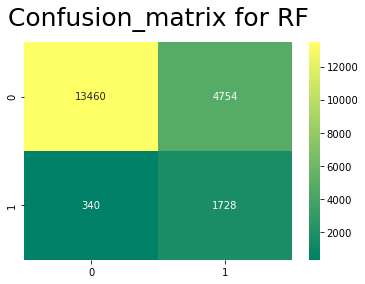

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test_bal,test_preds_rf),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix for RF', y=1.05, size=25)

## Gridsearch

In [47]:
from sklearn.model_selection import GridSearchCV
# Подберем парметры поиском по сетке
param={'criterion':('entropy', 'gini'),  'n_estimators':np.arange(100,1000,100)}
gv=GridSearchCV(rf_bal,param,scoring='roc_auc',cv=5)
gv.fit(X_train_bal,y_train_bal)

D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={0: 1, 1: 9},
                                              criterion='entropy',
                                              n_estimators=150, n_jobs=-1),
             param_grid={'criterion': ('entropy', 'gini'),
                         'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900])},
             scoring='roc_auc')

In [50]:
print(gv.best_score_)
print(gv.best_estimator_)

0.8446881279079992
RandomForestClassifier(class_weight={0: 1, 1: 9}, n_estimators=800, n_jobs=-1)


In [49]:
rf_best=RandomForestClassifier(class_weight={0: 1, 1: 9}, n_estimators=800, n_jobs=-1)
rf_best.fit(X_train_bal, y_train_bal)
train_preds_rf = rf_best.predict(X_train_bal)
test_preds_rf = rf_best.predict(X_test_bal)
print('Площадь под рок кривой на трейне',roc_auc_score( y_train_bal, train_preds_rf))
print('Площадь под рок кривой на тесте',roc_auc_score(y_test_bal, test_preds_rf))

<ipython-input-49-a33852f7fe6d>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_best.fit(X_train_bal, y_train_bal)


Площадь под рок кривой на трейне 0.8068102034316487
Площадь под рок кривой на тесте 0.7870491835833554


В результате работы поиска по сетке не добились улучшения качества на тесте